# 아마존 + 월마트 리뷰 데이터 

## - 모듈 불러오고 전처리

In [1]:
import os
import warnings
warnings.filterwarnings(action='ignore')

try:
    import pandas as pd
except:
    !pip install pandas
    import pandas as pd   

try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np
    
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt
    
try:
    import seaborn as sns
except:
    !pip install seaborn
    import seaborn as sns
    
try:
    import nltk
    from nltk import word_tokenize
    from nltk.stem import SnowballStemmer
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    nltk.download('stopwords')
    nltk.download('punkt')
except:
    !pip install nltk
    import nltk
    from nltk import word_tokenize
    from nltk.stem import SnowballStemmer
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    nltk.download('stopwords')
    nltk.download('punkt')
    
try:
    import re
except:
    !pip install re
    import re

try:
    import tensorflow
except:
    !pip install tensorflow
    
    
try:
    from tqdm import tqdm
except:
    !pip install tqdm
    from tqdm import tqdm

try:
    import gensim
    from gensim.models import Word2Vec, word2vec
except:
    !pip install gensim
    import gensim
    from gensim.models import Word2Vec, word2vec
    
try:
    import multiprocessing
except:
    !pip install multiprocessing
    import multiprocessing
    
try:
    from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
    from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
    from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
    from sklearn.svm import SVC
    from sklearn.decomposition import TruncatedSVD
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import MultinomialNB
except:
    !pip install sklearn
    from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
    from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
    from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
    from sklearn.svm import SVC
    from sklearn.decomposition import TruncatedSVD
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import MultinomialNB
    

try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    from xgboost import XGBRegressor
except:
    !pip install xgboost
    import xgboost as xgb
    from xgboost import XGBClassifier
    from xgboost import XGBRegressor
    

try:
    from keras.utils import np_utils
    from keras.preprocessing import sequence, text
    from keras.models import Sequential
    from keras.layers.recurrent import LSTM, GRU
    from keras.layers.core import Dense, Activation, Dropout
    from keras.layers.embeddings import Embedding
    from keras.layers.normalization import BatchNormalization
    from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
    from keras.callbacks import EarlyStopping
except:
    !pip install keras
    from keras.utils import np_utils
    from keras.preprocessing import sequence, text
    from keras.models import Sequential
    from keras.layers.recurrent import LSTM, GRU
    from keras.layers.core import Dense, Activation, Dropout
    from keras.layers.embeddings import Embedding
    from keras.layers.normalization import BatchNormalization
    from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
    from keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jin-u\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jin-u\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# 아마존과 월마트 데이터를 불러옴

amazon = pd.read_csv('./data/amazon_comment_seaweed_chip_result.csv')
amazon = amazon.drop(amazon.columns[0], axis = 1)
walmart = pd.read_csv('./data/walmart.csv') 

In [3]:
# 아마존 데이터 comment_date / star_rating 자르기

def name_cut(x):
    x = x.split('on ')[1]
    return x  

amazon["comment_date"] = amazon["comment_date"].apply(name_cut)

def name_cut(x):
    x = x.split(" out")[0]
    x = float(x)
    return x  

amazon["star_rating"] = amazon["star_rating"].apply(name_cut)

In [4]:
# 아마존 + 월마트 데이터 합치기

review = pd.concat([amazon['comment'], walmart['comment']], axis = 0) 
score = pd.concat([amazon['star_rating'], walmart['score']], axis = 0) 
author = pd.concat([amazon['comment_author'], walmart['author']], axis = 0)
date = pd.concat([amazon['comment_date'], walmart['date']], axis = 0)
title = pd.concat([amazon['comment_title'], walmart['title']], axis = 0)

review = pd.DataFrame({'date': date, 'title' : title, 'review': review, 'score': score, 'author': author})

In [5]:
# 불용어 및 stemmer 정의

stop_words = set(stopwords.words("english"))
stop_words.update(("yum", "yummy", "love", "loves", "great", "good", "better", "amazing", "buying", "found", "get", "like", "loved", 'maybe', 'may', 'could', 'awesome', 
                   'definitely', 'perfect' , 'best', 'okay', 'excellent', 'disappointed', 'right', 'nice', 'however', 'maybe', 'pretty', 'thank', 'wonderful', 'terrible', 
                   'unfortunately', 'awful', 'horrible', 'worst', 'wont', 'surprised', 'one', 'bad', 'actually', 'really', 'would', 'g', 'nd', 'feoooooooooooo', 'eh', 'ugh'
                    'everybody', 'sometime', 'state', 'fan', 'generally', 'edge', 'report', 'gross', 'buy', 'ewwwwwwww'
))
stemmer = SnowballStemmer("english")
TEXT_CLEANING_RE = "\([^)]*\|s\b|@\S+|https?:\S+|http?:\S|[^a-zA-Z]+"

In [6]:
# 축약어 리스트

contraction_mapping = {"won't": "will not",  "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                       "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                       "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                       "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                       "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                       "you're": "you are", "you've": "you have"}

In [7]:
# 전처리 함수

def preprocess(text, stem=False):
    newString = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])  

    tokens = []
    for token in newString.split():
        if token not in stop_words and len(token) > 1:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return ", ".join(tokens)

In [8]:
review['cleaned_review'] = review['review'].apply(lambda x: preprocess(x))

In [9]:
# null 값 확인

review.isnull().sum()

date              0
title             1
review            1
score             0
author            1
cleaned_review    0
dtype: int64

In [10]:
review[review['review'].isnull()]

,date,title,review,score,author,cleaned_review
2127,"June 4, 2018",The packaging sucks very disappointed,NaN,1.0,Sydney,nan


In [11]:
# null 값 제거

review.replace(' ',np.nan , inplace = True)
review.dropna(axis = 0 , inplace = True, subset = ['review'])

In [12]:
# 1~2: 0 (부정) / 3~5: 1 (긍정) 매핑

df = review
X = df['cleaned_review']
y_dict = {1.0:0, 2.0:0, 3.0:1, 4.0:1, 5.0:1}
y = df['score'].map(y_dict)

In [13]:
# train, test 분리

x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                stratify=y, 
                                                random_state=42, 
                                                test_size=0.2, shuffle=True)

In [14]:
print (x_train.shape)
print (x_test.shape)

(4622,)
(1156,)


## - Building Basic Models 

In [15]:
# 모델 평가 지표 시각화 함수

def model_Evaluate(model, x_test):
    
    # Predict values for Test dataset
    y_pred = model.predict(x_test)

    # Print the evaluation metrics for the dataset.
    print(model.score(x_test, y_test))
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    
prediction = dict()

In [16]:
# cross-validation 함수

def validation(model, x_train):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 0)
    score = cross_val_score(model, x_train, y_train, cv = skf)
    score_mean = score.mean()
    plt.show()

    return score_mean  

### Embedding 1) CountVectorizer

In [17]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 2))

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(x_train) + list(x_test))
xtrain_ctv =  ctv.transform(x_train) 
xtest_ctv = ctv.transform(x_test)

### - Logistic Regression

0.9065743944636678
              precision    recall  f1-score   support

           0       0.84      0.49      0.62       179
           1       0.91      0.98      0.95       977

    accuracy                           0.91      1156
   macro avg       0.88      0.73      0.78      1156
weighted avg       0.90      0.91      0.90      1156



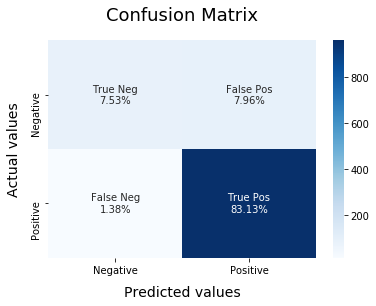

In [18]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, y_train)

prediction['Logistic'] = clf.predict(xtest_ctv)
validation(clf, xtrain_ctv)
model_Evaluate(clf, xtest_ctv)

### Embedding 2) TfidVectorizer

In [19]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',
            ngram_range=(1, 2), use_idf=1, smooth_idf=1, sublinear_tf=1)

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(x_train) + list(x_test))
xtrain_tfv =  tfv.transform(x_train) 
xtest_tfv = tfv.transform(x_test)

### - Logistic Regression

0.8814878892733564
              precision    recall  f1-score   support

           0       0.98      0.24      0.39       179
           1       0.88      1.00      0.93       977

    accuracy                           0.88      1156
   macro avg       0.93      0.62      0.66      1156
weighted avg       0.89      0.88      0.85      1156



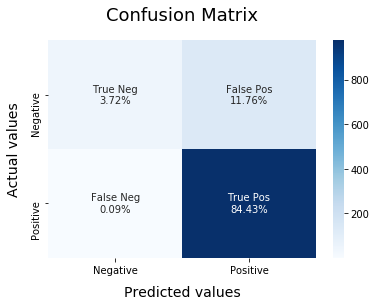

In [20]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, y_train)

prediction['Logistic_TFIDF'] = clf.predict(xtest_tfv)
model_Evaluate(clf, xtest_tfv)

### - Naive Bayes

0.8788927335640139
              precision    recall  f1-score   support

           0       1.00      0.22      0.36       179
           1       0.87      1.00      0.93       977

    accuracy                           0.88      1156
   macro avg       0.94      0.61      0.65      1156
weighted avg       0.89      0.88      0.84      1156



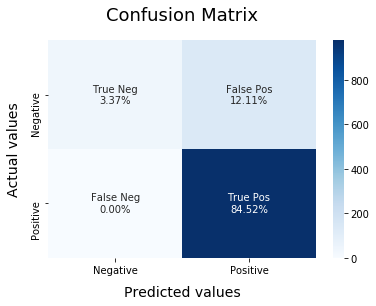

In [21]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, y_train)

prediction['Naive Bayes_TFIDF'] = clf.predict(xtest_tfv)
model_Evaluate(clf, xtest_tfv)

### - SVM

In [22]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xtest_svd = svd.transform(xtest_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xtest_svd_scl = scl.transform(xtest_svd)

0.8866782006920415
              precision    recall  f1-score   support

           0       0.85      0.32      0.47       179
           1       0.89      0.99      0.94       977

    accuracy                           0.89      1156
   macro avg       0.87      0.66      0.70      1156
weighted avg       0.88      0.89      0.86      1156



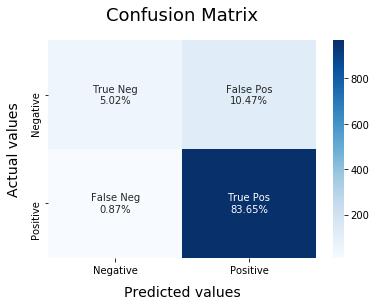

In [23]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, y_train)

prediction['SVM_TFIDF'] = clf.predict(xtest_svd_scl)
model_Evaluate(clf, xtest_svd_scl)

### - xgboost

0.9057093425605537
              precision    recall  f1-score   support

           0       0.87      0.46      0.60       179
           1       0.91      0.99      0.95       977

    accuracy                           0.91      1156
   macro avg       0.89      0.72      0.77      1156
weighted avg       0.90      0.91      0.89      1156



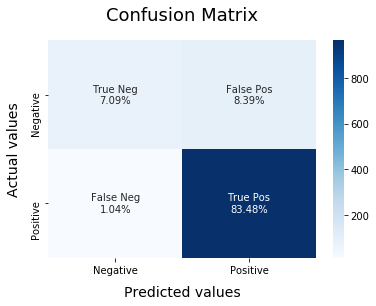

In [24]:
# Fitting a simple xgboost on Counts
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_ctv.tocsc(), y_train)

prediction['XGboost'] = clf.predict(xtest_ctv.tocsc())
model_Evaluate(clf, xtest_ctv.tocsc())

0.9005190311418685
              precision    recall  f1-score   support

           0       0.85      0.44      0.58       179
           1       0.91      0.99      0.94       977

    accuracy                           0.90      1156
   macro avg       0.88      0.71      0.76      1156
weighted avg       0.90      0.90      0.89      1156



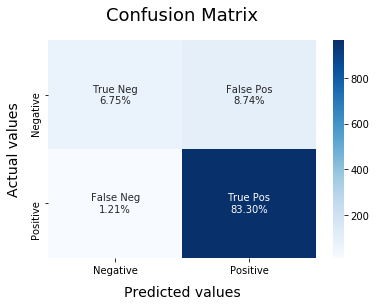

In [25]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), y_train)

prediction['XGboost_TFIDF'] = clf.predict(xtest_tfv.tocsc())
model_Evaluate(clf, xtest_tfv.tocsc())

0.8970588235294118
              precision    recall  f1-score   support

           0       0.83      0.42      0.56       179
           1       0.90      0.98      0.94       977

    accuracy                           0.90      1156
   macro avg       0.86      0.70      0.75      1156
weighted avg       0.89      0.90      0.88      1156



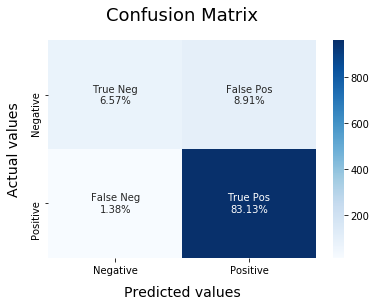

In [26]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, y_train)

prediction['XGboost_TFIDF_SVD'] = clf.predict(xtest_svd)
model_Evaluate(clf, xtest_svd)

### Embedding 3) glove

In [27]:
embeddings_index = {}
f = open('./data/glove.840B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

24616it [00:03, 7418.38it/s]

Found 24616 word vectors.


In [28]:
def sent2vec(s):
    words = str(s).lower().encode().decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [29]:
xtrain_glove = [sent2vec(x) for x in tqdm(x_train)]
xvalid_glove = [sent2vec(x) for x in tqdm(x_test)]

100%|████████████████████████████████████████████████████████████████████████████| 1156/1156 [00:00<00:00, 3567.64it/s]


In [30]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

[22:02:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.8901384083044983
              precision    recall  f1-score   support

           0       0.84      0.36      0.50       179
           1       0.89      0.99      0.94       977

    accuracy                           0.89      1156
   macro avg       0.87      0.67      0.72      1156
weighted avg       0.89      0.89      0.87      1156



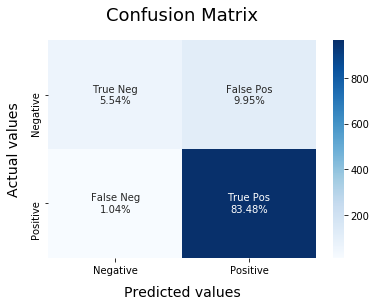

In [31]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(xtrain_glove, y_train)

prediction['XGboost_glove'] = clf.predict(xvalid_glove)
model_Evaluate(clf, xvalid_glove)

## - Deep Learning

### - ANN

In [32]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [33]:
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(y_train)
yvalid_enc = np_utils.to_categorical(y_test)

In [34]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [35]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=5, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

Epoch 1/5
73/73 [==============================] - 0s 7ms/step - loss: 0.6136 - val_loss: 0.4203
Epoch 2/5
73/73 [==============================] - 0s 3ms/step - loss: 0.3708 - val_loss: 0.3094
Epoch 3/5
73/73 [==============================] - 0s 3ms/step - loss: 0.2971 - val_loss: 0.2929
Epoch 4/5
73/73 [==============================] - 0s 3ms/step - loss: 0.2689 - val_loss: 0.2938
Epoch 5/5
73/73 [==============================] - 0s 3ms/step - loss: 0.2435 - val_loss: 0.2936


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.77      0.40      0.52       179
           1       0.90      0.98      0.94       977

    accuracy                           0.89      1156
   macro avg       0.84      0.69      0.73      1156
weighted avg       0.88      0.89      0.87      1156



Text(0.5, 1, 'Confusion Matrix')

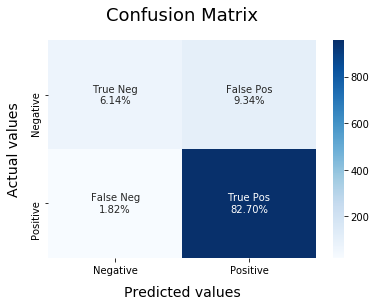

In [36]:
prediction['ANN_glove'] = model.predict_classes(xvalid_glove_scl)

y_pred = model.predict(xvalid_glove_scl)

print(classification_report(yvalid_enc.argmax(axis=1), y_pred.argmax(axis=1)))

cf_matrix = confusion_matrix(yvalid_enc.argmax(axis=1), y_pred.argmax(axis=1))

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
            xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### - LSTM

In [37]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 5

token.fit_on_texts(list(x_train) + list(x_test))
xtrain_seq = token.texts_to_sequences(x_train)
xvalid_seq = token.texts_to_sequences(x_test)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [38]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████████████████████████████████████████████████████████████████████| 6163/6163 [00:00<00:00, 342368.36it/s]


In [39]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [40]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, verbose=1, validation_data=(xvalid_pad, yvalid_enc))

Epoch 1/100
10/10 [==============================] - 1s 105ms/step - loss: 0.5048 - val_loss: 0.4252
Epoch 2/100
10/10 [==============================] - 1s 76ms/step - loss: 0.4290 - val_loss: 0.4128
Epoch 3/100
10/10 [==============================] - 1s 77ms/step - loss: 0.4147 - val_loss: 0.3937
Epoch 4/100
10/10 [==============================] - 1s 75ms/step - loss: 0.3963 - val_loss: 0.3858
Epoch 5/100
10/10 [==============================] - 1s 77ms/step - loss: 0.3825 - val_loss: 0.3832
Epoch 6/100
10/10 [==============================] - 1s 79ms/step - loss: 0.3740 - val_loss: 0.3778
Epoch 7/100
10/10 [==============================] - 1s 83ms/step - loss: 0.3788 - val_loss: 0.3749
Epoch 8/100
10/10 [==============================] - 1s 83ms/step - loss: 0.3760 - val_loss: 0.3725
Epoch 9/100
10/10 [==============================] - 1s 85ms/step - loss: 0.3740 - val_loss: 0.3564
Epoch 10/100
10/10 [==============================] - 1s 82ms/step - loss: 0.3668 - val_loss: 0.366

10/10 [==============================] - 1s 85ms/step - loss: 0.2008 - val_loss: 0.3864
Epoch 83/100
10/10 [==============================] - 1s 85ms/step - loss: 0.1956 - val_loss: 0.3854
Epoch 84/100
10/10 [==============================] - 1s 86ms/step - loss: 0.1990 - val_loss: 0.3758
Epoch 85/100
10/10 [==============================] - 1s 83ms/step - loss: 0.2056 - val_loss: 0.3879
Epoch 86/100
10/10 [==============================] - 1s 82ms/step - loss: 0.1826 - val_loss: 0.4086
Epoch 87/100
10/10 [==============================] - 1s 83ms/step - loss: 0.1887 - val_loss: 0.4095
Epoch 88/100
10/10 [==============================] - 1s 83ms/step - loss: 0.1872 - val_loss: 0.4109
Epoch 89/100
10/10 [==============================] - 1s 82ms/step - loss: 0.2033 - val_loss: 0.4236
Epoch 90/100
10/10 [==============================] - 1s 84ms/step - loss: 0.2026 - val_loss: 0.3933
Epoch 91/100
10/10 [==============================] - 1s 82ms/step - loss: 0.1975 - val_loss: 0.4145
Epo

              precision    recall  f1-score   support

           0       0.57      0.42      0.48       179
           1       0.90      0.94      0.92       977

    accuracy                           0.86      1156
   macro avg       0.74      0.68      0.70      1156
weighted avg       0.85      0.86      0.85      1156



Text(0.5, 1, 'Confusion Matrix')

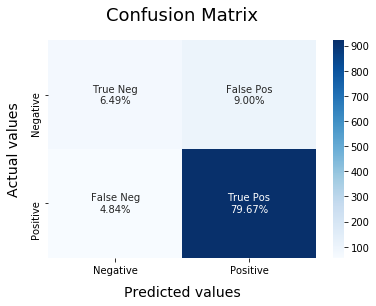

In [41]:
prediction['LSTM_glove'] = model.predict_classes(xvalid_pad)

y_pred = model.predict(xvalid_pad)

print(classification_report(yvalid_enc.argmax(axis=1), y_pred.argmax(axis=1)))

cf_matrix = confusion_matrix(yvalid_enc.argmax(axis=1), y_pred.argmax(axis=1))

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
            xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### - biLSTM

In [42]:
# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/100
10/10 [==============================] - 2s 183ms/step - loss: 0.5134 - val_loss: 0.4271
Epoch 2/100
10/10 [==============================] - 1s 123ms/step - loss: 0.4330 - val_loss: 0.4021
Epoch 3/100
10/10 [==============================] - 1s 124ms/step - loss: 0.4082 - val_loss: 0.4004
Epoch 4/100
10/10 [==============================] - 1s 128ms/step - loss: 0.3926 - val_loss: 0.3806
Epoch 5/100
10/10 [==============================] - 1s 130ms/step - loss: 0.3793 - val_loss: 0.3775
Epoch 6/100
10/10 [==============================] - 1s 132ms/step - loss: 0.3707 - val_loss: 0.3672
Epoch 7/100
10/10 [==============================] - 1s 128ms/step - loss: 0.3683 - val_loss: 0.3693
Epoch 8/100
10/10 [==============================] - 1s 124ms/step - loss: 0.3670 - val_loss: 0.3579
Epoch 9/100
10/10 [==============================] - 1s 120ms/step - loss: 0.3585 - val_loss: 0.3623
Epoch 10/100
10/10 [==============================] - 1s 118ms/step - loss: 0.3615 - val_lo

              precision    recall  f1-score   support

           0       0.60      0.29      0.39       179
           1       0.88      0.97      0.92       977

    accuracy                           0.86      1156
   macro avg       0.74      0.63      0.66      1156
weighted avg       0.84      0.86      0.84      1156



Text(0.5, 1, 'Confusion Matrix')

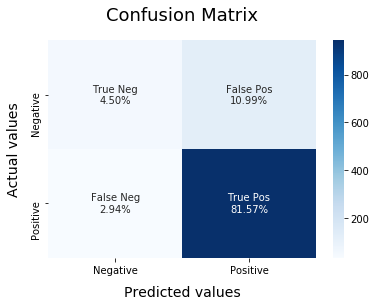

In [43]:
prediction['BiLSTM_glove'] = model.predict_classes(xvalid_pad)

y_pred = model.predict(xvalid_pad)

print(classification_report(yvalid_enc.argmax(axis=1), y_pred.argmax(axis=1)))

cf_matrix = confusion_matrix(yvalid_enc.argmax(axis=1), y_pred.argmax(axis=1))

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
            xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### - GRU

In [44]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(200, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(200, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/100
10/10 [==============================] - 2s 204ms/step - loss: 0.5045 - val_loss: 0.4556
Epoch 2/100
10/10 [==============================] - 1s 144ms/step - loss: 0.4292 - val_loss: 0.3984
Epoch 3/100
10/10 [==============================] - 1s 141ms/step - loss: 0.4011 - val_loss: 0.3885
Epoch 4/100
10/10 [==============================] - 1s 143ms/step - loss: 0.3844 - val_loss: 0.3739
Epoch 5/100
10/10 [==============================] - 1s 140ms/step - loss: 0.3836 - val_loss: 0.3743
Epoch 6/100
10/10 [==============================] - 1s 139ms/step - loss: 0.3794 - val_loss: 0.3741
Epoch 7/100
10/10 [==============================] - 1s 145ms/step - loss: 0.3851 - val_loss: 0.3546
Epoch 8/100
10/10 [==============================] - 1s 148ms/step - loss: 0.3751 - val_loss: 0.3574
Epoch 9/100
10/10 [==============================] - 1s 146ms/step - loss: 0.3756 - val_loss: 0.3625
Epoch 10/100
10/10 [==============================] - 1s 143ms/step - loss: 0.3724 - val_lo

              precision    recall  f1-score   support

           0       0.67      0.26      0.37       179
           1       0.88      0.98      0.92       977

    accuracy                           0.87      1156
   macro avg       0.77      0.62      0.65      1156
weighted avg       0.84      0.87      0.84      1156



Text(0.5, 1, 'Confusion Matrix')

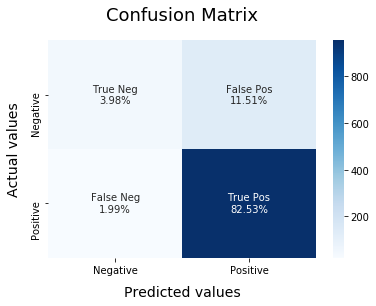

In [45]:
prediction['GRU_glove'] = model.predict_classes(xvalid_pad)

y_pred = model.predict(xvalid_pad)

print(classification_report(yvalid_enc.argmax(axis=1), y_pred.argmax(axis=1)))

cf_matrix = confusion_matrix(yvalid_enc.argmax(axis=1), y_pred.argmax(axis=1))

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
            xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## - 시각화: model 비교

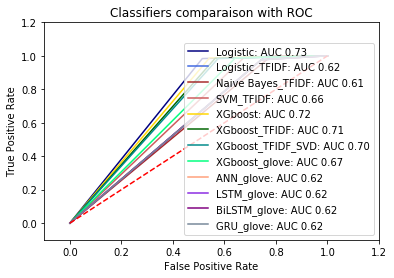

In [46]:
# ROC 곡선

colors_1 = ['navy', 'royalblue', 'brown', 'indianred', 'gold', 'darkgreen', 'darkcyan', 'springgreen', 'lightyellow']

colors_2 = ['lightsalmon', 'blueviolet', 'purple', 'lightslategrey']

cmp_1 = 0
for model, predicted in prediction.items():
    if model in ('Logistic', 'Logistic_TFIDF', 'Naive Bayes_TFIDF',
                 'SVM_TFIDF', 'XGboost', 'XGboost_TFIDF', 'XGboost_TFIDF_SVD',
                 'XGboost_glove'):
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate, true_positive_rate, colors_1[cmp_1], label='%s: AUC %0.2f'% (model,roc_auc))
        cmp_1 += 1

cmp_2 = 0
for model, predicted in prediction.items():
    if model in ('ANN_glove', 'LSTM_glove', 'BiLSTM_glove', 'GRU_glove'):
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred.argmax(axis=1))
        roc_auc = auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate, true_positive_rate, colors_2[cmp_2], label='%s: AUC %0.2f'% (model,roc_auc))
        cmp_2 += 1
        
plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.rc('figure', figsize=(12, 8))
plt.show()

In [47]:
# 정확도 비교

model = ['Logistic', 'Logistic_TFIDF', 'Naive Bayes_TFIDF',
        'SVM_TFIDF', 'XGboost', 'XGboost_TFIDF', 'XGboost_TFIDF_SVD',
        'XGboost_glove']
accuracy = []

for m in model:
    accuracy.append(accuracy_score(y_test, prediction[m]))
       
accuracy_list = pd.DataFrame({'model': model, 'accuracy' : accuracy})

In [48]:
accuracy_list

,model,accuracy
0,Logistic,0.906574
1,Logistic_TFIDF,0.881488
2,Naive Bayes_TFIDF,0.878893
3,SVM_TFIDF,0.886678
4,XGboost,0.905709
5,XGboost_TFIDF,0.900519
6,XGboost_TFIDF_SVD,0.897059
7,XGboost_glove,0.890138


Text(0.5, 1.0, 'Classifiers comparaison with accuracy')

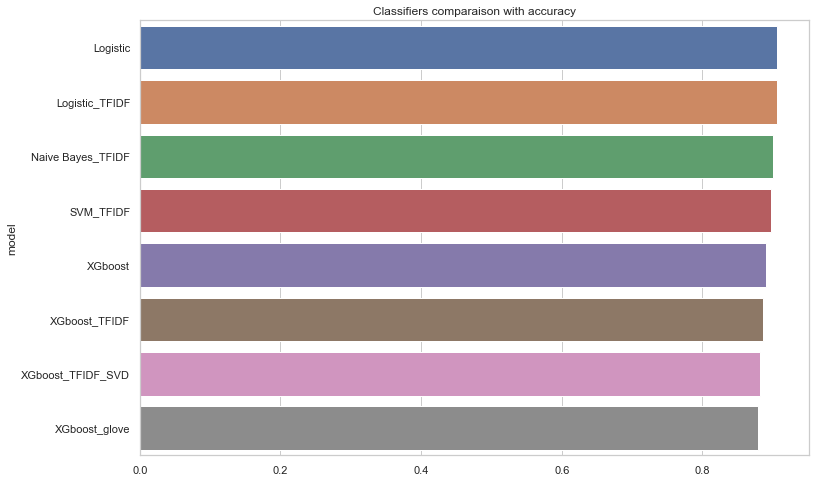

In [49]:
y = accuracy_list['model']
x = accuracy_list['accuracy'].sort_values(ascending=False).values

sns.set(style="whitegrid")
ax = sns.barplot(x=x, y=y)
ax.set_title('Classifiers comparaison with accuracy')

## - 최종 시각화: 회귀계수를 이용한 키워드 확인 

### - XGBoost

In [ ]:
# Fitting a simple xgboost on Counts
import xgboost as xgb
xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, booster ='gblinear')
xgb_result = xgb.fit(xtrain_ctv.tocsc(), y_train)

features = ctv.get_feature_names()
feature_coefs = pd.DataFrame({'word' : features, 'coefficient': xgb.coef_})

feature_coefs = feature_coefs.sort_values(['coefficient', 'word'], ascending = [0, 1])
feature_coefs.head(20)

[22:05:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bytree, max_depth, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [ ]:
print('-Top 20 positive-')
print(feature_coefs.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')        
print(feature_coefs.tail(20).to_string(index=False)) 

### - Logistic regression

In [ ]:
log = LogisticRegression(C=1.0)
log_result = log.fit(xtrain_ctv, y_train)

features = ctv.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(features, log_result.coef_[0])),
    columns = ['word', 'coefficient'])

feature_coefs = feature_coefs.sort_values(['coefficient', 'word'], ascending = [0, 1])
feature_coefs.head(20)

In [ ]:
print('-Top 20 positive-')
print(feature_coefs.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')        
print(feature_coefs.tail(20).to_string(index=False)) 

In [ ]:
p = feature_coefs.head(20)
n = feature_coefs.tail(20)

In [ ]:
p_y = p['word'].values
p_x = p['coefficient'].sort_values(ascending=False).values

n_y = n['word'].values
n_x = n['coefficient'].sort_values().values

sns.set(style="whitegrid")
ax1 = sns.barplot(x=p_x, y=p_y, palette="Blues", label=p_y)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
ax1.set_title('Positive keywords')
plt.figure(figsize=(10,20))
plt.show()

ax2 = sns.barplot(x=n_x, y=n_y, palette="OrRd", label=n_y)
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position('left')
ax2.set_title('Negative keywords')
plt.figure(figsize=(10,20))
plt.show()